## 1. Transform data to fingerprint

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the data
active_data = pd.read_csv("./CHEMBI_active.csv")

smiles_list = active_data['canonical_smiles']

# Generate 2048-bit Morgan fingerprint
fp_2048 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2, nBits=2048) for smile in smiles_list]
# Convert fingerprints to a list of lists
fps_lists = [list(fp) for fp in fp_2048]

# Create DataFrame
df_fp = pd.DataFrame(fps_lists)
df_fp.columns = [f'Bit_{i}' for i in range(df_fp.shape[1])]  # Naming columns as Bit_0, Bit_1, etc.
print(df_fp.shape)
df_fp.dropna()
print(df_fp.shape)

(1981, 2048)
(1981, 2048)


## 2. PCA

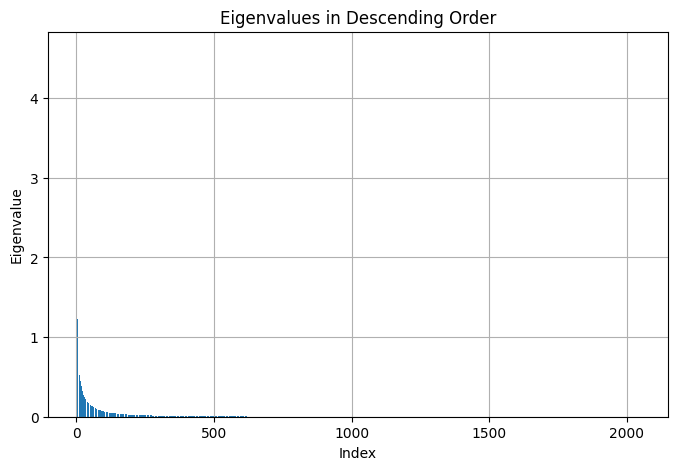

In [2]:
# mean-center the data
means = df_fp.mean()

# Subtract the mean from each column to center the data
df_centered = df_fp - means

# Compute the KxK covariance matrix S
S = np.cov(df_centered, rowvar=False)
# compute the eigenvalues
# Perform eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(S)

# Sorting eigenvalues in descending order
sorted_eigenvalues = eigenvalues[::-1]

# Plotting the eigenvalues
plt.figure(figsize=(8,5))
plt.bar(range(len(sorted_eigenvalues)),sorted_eigenvalues)
plt.title("Eigenvalues in Descending Order")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

In [3]:
# find the top PCs covers 90% variance, reduce the fingerprint to this dimension
total = sum(sorted_eigenvalues)*0.9
k = 2
explained = sum(sorted_eigenvalues[:2])
while explained < total:
    k += 1
    explained += sorted_eigenvalues[k-1]

print(f'The PC number should be: {k} in order to capture at least 90% variability.')


The PC number should be: 223 in order to capture at least 90% variability.


In [4]:
# a rough view on the PCA-reduced data
PCs = [eigenvectors[:,-i] for i in range(1,224)]
projected_data =  [np.dot(df_centered, PC) for PC in PCs]
data = pd.DataFrame(projected_data).T
data[:5]

,0,1,2,3,4,5,6,7,8,9,...,213,214,215,216,217,218,219,220,221,222
0,-0.789655,1.313849,-0.578624,0.832020,-0.417255,0.646945,-0.343526,1.372467,-0.681542,-0.660349,...,-0.222682,-0.041736,0.199218,-0.190750,0.101426,-0.010030,-0.014702,0.171356,0.223773,0.286314
1,-0.726135,0.843063,-0.668019,0.546519,-0.403017,0.940562,-0.288938,1.708420,-0.461336,-0.806381,...,-0.212849,-0.181377,0.176605,-0.128572,0.204487,-0.008376,0.014834,0.246303,0.191897,0.149451
2,-0.986285,0.227785,-1.053717,0.245424,-0.170333,1.047398,-0.810814,1.735733,-0.670862,-0.404641,...,0.082104,-0.023861,-0.278831,0.010739,0.006221,0.205447,0.154764,-0.080789,-0.154434,-0.057913
3,-1.335934,-0.188288,-0.274767,-0.335101,-0.524700,0.805994,-0.518312,1.009227,-0.554994,0.288590,...,0.159539,0.101164,-0.305467,0.187518,0.184127,0.283908,0.080642,-0.246754,-0.126371,-0.037131
4,-1.252765,0.056802,-0.224038,-0.651428,-0.813626,0.980251,-0.977739,0.488794,-0.319336,0.357762,...,0.269263,-0.022443,-0.375018,-0.059845,0.072477,0.433362,0.015816,-0.235773,-0.143265,-0.138907


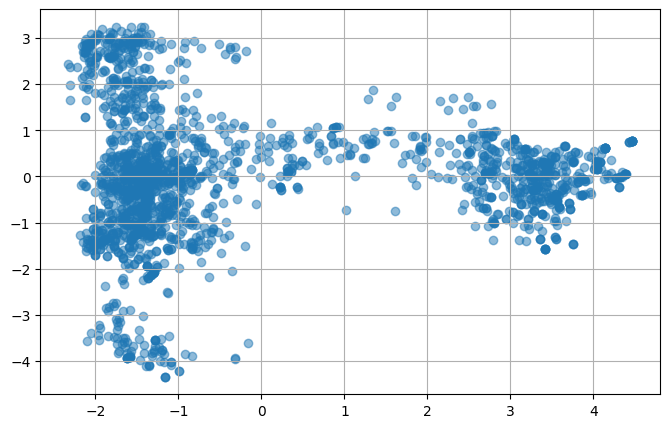

In [5]:
# save the reduced data, we have provided it under the folder 'data'
# data.to_csv('outlier_cleaned.csv')
# plot the reduced data and to check with our team members if the data is rightly reduced without package.
plt.figure(figsize=(8,5))
plt.scatter(data[0],data[1],alpha = 0.5)
plt.grid()
plt.show()